In [90]:
# pip install pandas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [91]:
dir_path = 'analysis/custom'
run_name = 'baseline'

In [92]:
# Load the data
item_log_df = pd.read_csv(f'{dir_path}/{run_name}/item_log.csv')
turtlebot_data_df = pd.read_csv(f'{dir_path}/{run_name}/turtlebot_data.csv')
item_data_df = pd.read_csv(f'{dir_path}/{run_name}/item_data.csv')

In [93]:
# Setting the threshold for identifying potential collisions
collision_threshold = -0.2

In [94]:
# Processing for cumulative item value and distance traveled
item_value_data = item_log_df[['timestamp', 'total_value']]
color_contribution_data = item_log_df[['timestamp', 'red_value', 'green_value', 'blue_value']]
color_contribution_data['green_value'] += color_contribution_data['red_value']
color_contribution_data['blue_value'] += color_contribution_data['green_value']
baseline_merged_data = turtlebot_data_df.groupby('Time').agg({'Distance Traveled':'sum'})
item_value_changes = item_value_data[item_value_data['total_value'].diff() > 0]
potential_collisions = turtlebot_data_df[turtlebot_data_df['Linear Acceleration'] < collision_threshold].groupby('Time').agg({'Distance Traveled': 'first'})

/tmp/ipykernel_53652/2552665020.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  color_contribution_data['green_value'] += color_contribution_data['red_value']
/tmp/ipykernel_53652/2552665020.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  color_contribution_data['blue_value'] += color_contribution_data['green_value']


In [95]:
# Processing for item value vs timestamp
pickup_times = item_data_df[item_data_df['Item Value'] != 0]
dropoff_times = item_data_df[item_data_df['Item Value'] == 0]
combined_item_events = pd.concat([pickup_times, dropoff_times]).sort_values(by='Time').reset_index(drop=True)


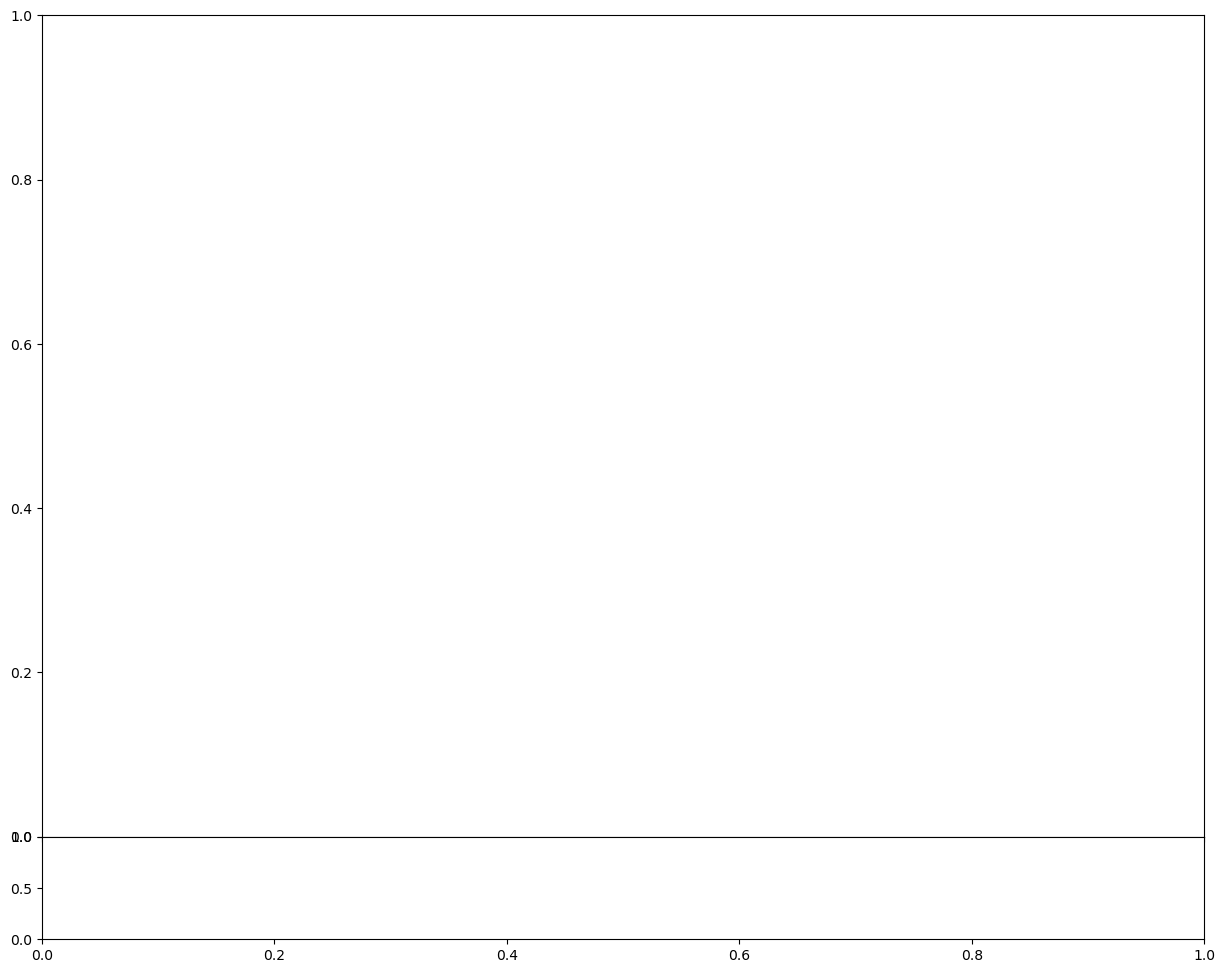

In [96]:
# Create the plot
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15, 12), gridspec_kw={'height_ratios': [2, .25]})
fig.subplots_adjust(hspace=0)

In [97]:
# Top graph: Cumulative Item Value and Distance Traveled with Color Contributions
axs[0].plot(item_value_data['timestamp'].to_numpy(), item_value_data['total_value'].to_numpy(), label='Cumulative Item Value', color='tab:purple', linestyle='--')

axs[0].fill_between(color_contribution_data['timestamp'], 0, color_contribution_data['red_value'], color='red', alpha=0.3, label='Red Contribution')
axs[0].fill_between(color_contribution_data['timestamp'], color_contribution_data['red_value'], color_contribution_data['green_value'], color='green', alpha=0.3, label='Green Contribution')
axs[0].fill_between(color_contribution_data['timestamp'], color_contribution_data['green_value'], color_contribution_data['blue_value'], color='blue', alpha=0.3, label='Blue Contribution')
axs[0].scatter(item_value_changes['timestamp'], item_value_changes['total_value'], color='black', label='Item Returned', marker='x')
axs[0].set_ylabel('Cumulative Item Value', color='tab:purple')
axs[0].tick_params(axis='y', labelcolor='tab:purple')

In [98]:
# Right Y-axis: Distance Traveled
ax2 = axs[0].twinx()
ax2.plot(baseline_merged_data.index.to_numpy(), baseline_merged_data['Distance Traveled'].to_numpy(), label='Distance Traveled', color='tab:green')
ax2.set_ylabel('Distance Traveled (meters)', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

ax2.scatter(potential_collisions.index.to_numpy(), potential_collisions['Distance Traveled'].to_numpy(), color='red', label='Potential Collision', marker='^', zorder=5)

In [99]:
# Bottom graph: Item Value vs Timestamp
for i in range(len(combined_item_events) - 1):
    axs[1].plot(combined_item_events.iloc[i:i+2]['Time'].to_numpy(), combined_item_events.iloc[i:i+2]['Item Value'].to_numpy(), linestyle='--', color='gray', alpha=0.5)
axs[1].scatter(pickup_times['Time'], pickup_times['Item Value'], c=pickup_times['Item Colour'], label='Item Pickup', marker='o')
axs[1].scatter(dropoff_times['Time'], dropoff_times['Item Value'], color='black', label='Item Dropoff', marker='x')
axs[1].set_ylabel('Item Value', color='tab:blue')
axs[1].tick_params(axis='y', labelcolor='tab:blue')
axs[1].set_ylim(-1, max(combined_item_events['Item Value']) + 1)
axs[1].set_yticks(np.arange(0, max(combined_item_events['Item Value']) + 1, 2))

axs[1].yaxis.set_major_locator(plt.MultipleLocator(5))


In [100]:
# Legends and titles
axs[0].legend(loc='upper left')
ax2.legend(loc='upper right')
axs[1].legend(loc='upper left')
axs[1].set_xlabel('Timestamp (seconds)')
plt.suptitle('Robot Performance, Cumulative Item Value with Color Contributions, and Item Collection Over Time')

plt.show()

<Figure size 640x480 with 0 Axes>

In [101]:
axs[0].grid()
ax2.grid()
axs[1].grid()

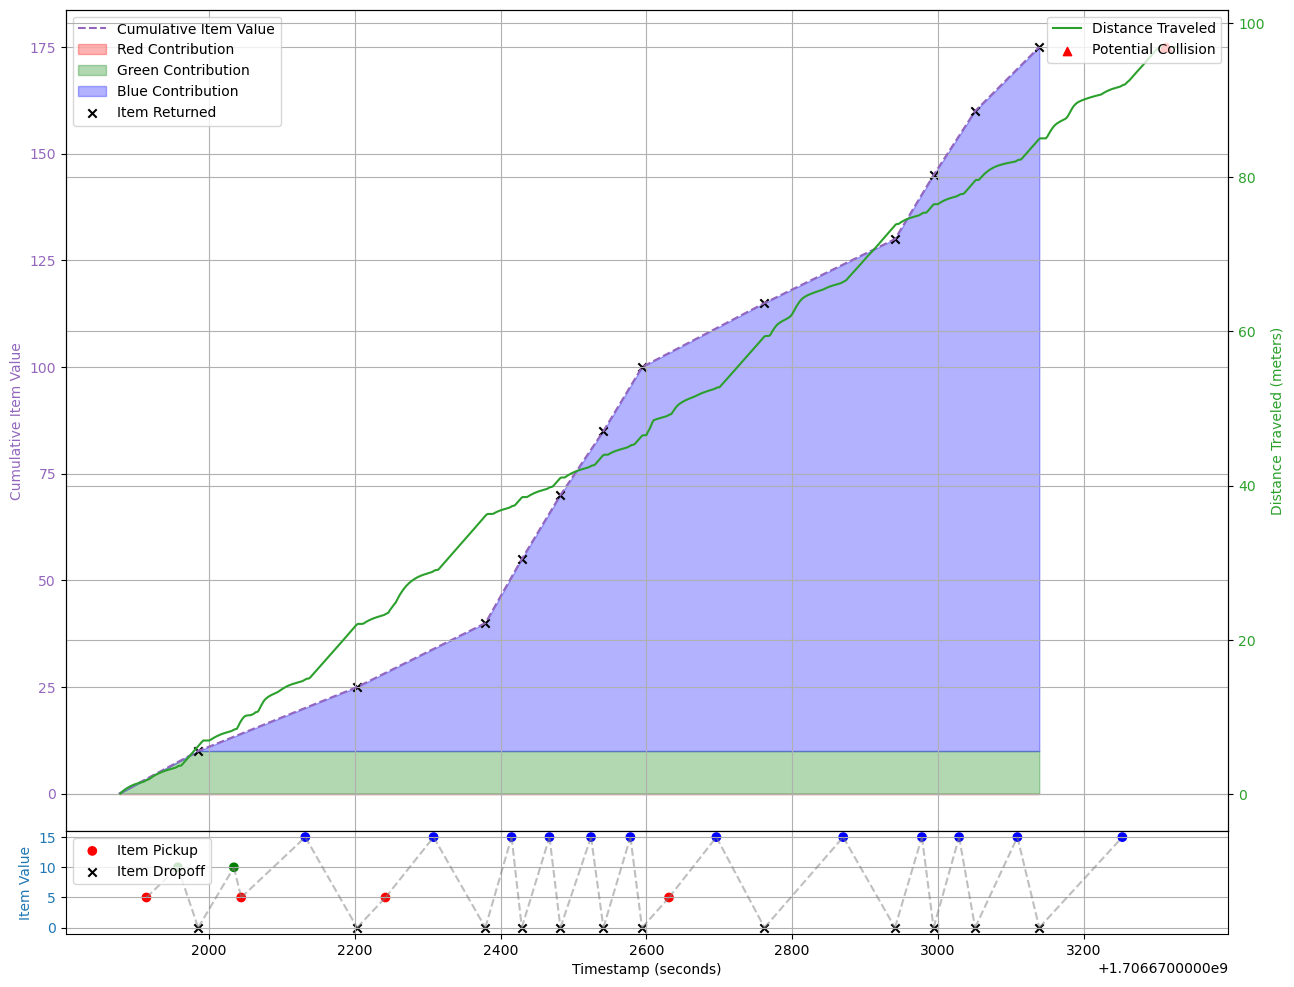

In [102]:
fig